# Import Libraries

In [1]:
# import os
import numpy as np
import pandas as pd

In [5]:
import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))

In [7]:
from features.mfcc_feature_extraction import mfcc_feature_extraction
from utils.visualisation import augmented_lables_count, plot_loss_curves, confusion_matrix_classes
from features.class_labels_encoding import encode_labels_to_categorical
from models.prepare_train_test_data import prepare_test_train_data
from models.model_design_and_training import create_model, train_model
from sklearn.metrics import classification_report
import bentoml

/Users/khubaib/Downloads/DeepRespNet/.venv/lib/python3.10/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore


# Load Dataset

In [8]:
# Location of Data Folder:
data_folder = '../../data/Respiratory_Sound_Data'

In [9]:
# Lung Audio Data Folder:
audio_data_folder = f'{data_folder}/audio_and_txt_files/'

In [10]:
# Test Audio Files:
audio1 = f'{audio_data_folder}104_1b1_Lr_sc_Litt3200.wav'
audio2 = f'{audio_data_folder}224_1b1_Tc_sc_Meditron.wav'
audio3 = f'{audio_data_folder}108_1b1_Al_sc_Meditron.wav'
audio4 = f'{audio_data_folder}182_1b1_Tc_sc_Meditron.wav'
audio5 = f'{audio_data_folder}223_1b1_Al_sc_Meditron.wav'
audio6 = f'{audio_data_folder}226_1b1_Pl_sc_LittC2SE.wav'


In [11]:
diagnosis_df = pd.read_csv('../../notebooks/patient_diagnosis_relabelled.csv')

In [12]:
diagnosis_df

,pid,diagnosis
0,101,Acute
1,102,Healthy
2,103,Chronic
3,104,Chronic
4,105,Acute
...,...,...
121,222,Chronic
122,223,Chronic
123,224,Healthy
124,225,Healthy


# Data Preprocessing

In [13]:
x_mfccs, y = mfcc_feature_extraction(dir_=audio_data_folder,diagnosis_df=diagnosis_df)

Processing 920 audio files...
Processed 50/920 files...
Processed 100/920 files...
Processed 150/920 files...
Processed 200/920 files...
Processed 250/920 files...
Processed 300/920 files...
Processed 350/920 files...
Processed 400/920 files...
Processed 450/920 files...
Processed 500/920 files...
Processed 550/920 files...
Processed 600/920 files...
Processed 650/920 files...
Processed 700/920 files...
Processed 750/920 files...
Processed 800/920 files...
Processed 850/920 files...
Processed 900/920 files...

Feature extraction completed!
Final dataset shape: (997, 52)
Label distribution: {'Acute': 450, 'Chronic': 337, 'Healthy': 210}


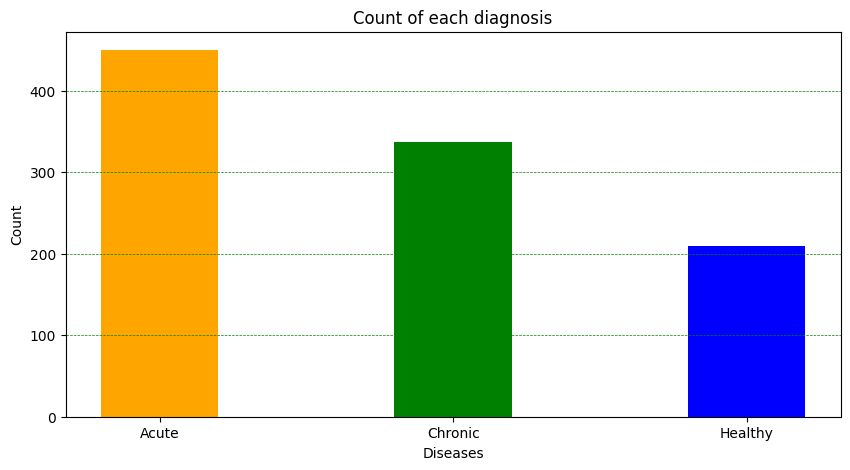

{'Acute': 450, 'Chronic': 337, 'Healthy': 210}


In [14]:
augmented_lables_count(y)

In [15]:
Y_data = encode_labels_to_categorical(y=y)

In [16]:
mfccs_features = np.array(x_mfccs)
lables = np.array(Y_data)

mfccs_features.shape , lables.shape

((997, 52), (997, 3))

In [17]:
# Assume mfccs_features and labels are already defined

(x_train, y_train), (x_val, y_val), (x_test, y_test) = prepare_test_train_data(mfccs_features, lables)

print("Training shapes:", x_train.shape, y_train.shape)
print("Validation shapes:", x_val.shape, y_val.shape)
print("Test shapes:", x_test.shape, y_test.shape)

Training shapes: (697, 1, 52) (697, 1, 3)
Validation shapes: (200, 1, 52) (200, 1, 3)
Test shapes: (100, 1, 52) (100, 1, 3)


# Model Development

In [18]:
deeprespnet_model = create_model()

In [19]:
deeprespnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1, 52)]              0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 1, 256)               66816     ['input_1[0][0]']             
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 1, 256)               0         ['conv1d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 1, 256)               1024      ['max_pooling1d[0][0]']   

## Train Model

In [20]:
history = train_model(deeprespnet_model,x_train,y_train,x_val,y_val)

Epoch 1/5
22/22 [==============================] - 8s 79ms/step - loss: 0.9784 - accuracy: 0.6098 - val_loss: 1.0233 - val_accuracy: 0.4750
Epoch 2/5
 8/22 [=========>....................] - ETA: 0s - loss: 0.8245 - accuracy: 0.6953

/Users/khubaib/Downloads/DeepRespNet/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 0s 21ms/step - loss: 0.7933 - accuracy: 0.6858 - val_loss: 1.0178 - val_accuracy: 0.4950
Epoch 3/5
22/22 [==============================] - 1s 33ms/step - loss: 0.6857 - accuracy: 0.7131 - val_loss: 0.9706 - val_accuracy: 0.5750
Epoch 4/5
22/22 [==============================] - 1s 26ms/step - loss: 0.5992 - accuracy: 0.7604 - val_loss: 0.9191 - val_accuracy: 0.6350
Epoch 5/5
22/22 [==============================] - 1s 23ms/step - loss: 0.5257 - accuracy: 0.7905 - val_loss: 0.8318 - val_accuracy: 0.6750
Model saved successfully with BentoML!


## Model Evaluation

In [21]:
deeprespnet_model.evaluate(x_train, y_train)

22/22 [==============================] - 0s 3ms/step - loss: 0.7944 - accuracy: 0.7016


[0.7944488525390625, 0.7015781998634338]

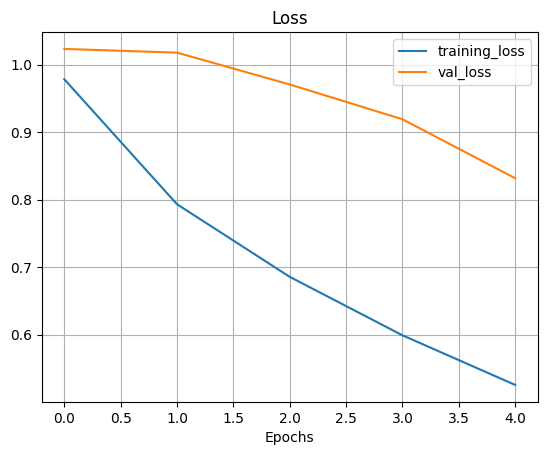

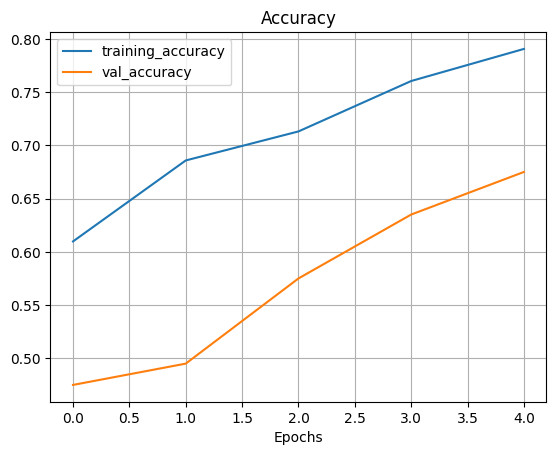

In [22]:
plot_loss_curves(history)

4/4 [==============================] - 1s 3ms/step


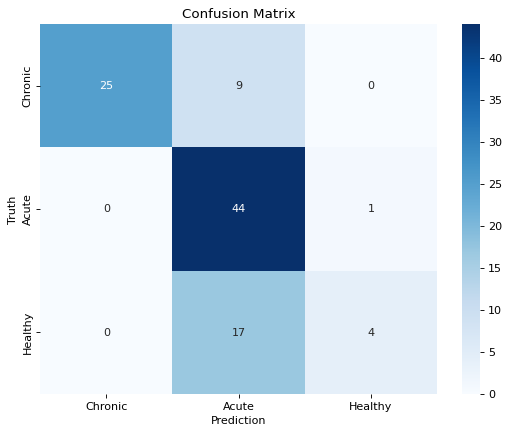

In [23]:
y_testclass, classpreds = confusion_matrix_classes(deeprespnet_model,x_test,y_test)

In [24]:
print(classification_report(y_testclass, classpreds, target_names=['Chronic', 'Acute', 'Healthy']))

              precision    recall  f1-score   support

     Chronic       1.00      0.74      0.85        34
       Acute       0.63      0.98      0.77        45
     Healthy       0.80      0.19      0.31        21

    accuracy                           0.73       100
   macro avg       0.81      0.63      0.64       100
weighted avg       0.79      0.73      0.70       100



In [25]:
result = deeprespnet_model.evaluate(x_train, y_train)

22/22 [==============================] - 0s 3ms/step - loss: 0.7944 - accuracy: 0.7016


In [26]:
type(result)

list

# Saving the model

In [27]:
deeprespnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# deeprespnet_model.save("./diagnosis_model8.h5")

/Users/khubaib/Downloads/DeepRespNet/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
deeprespnet_model.save("../models/deeprespnet_model.keras")

In [30]:
from keras.models import load_model
# Step 2: Load it back (as required by BentoML)
loaded_model = load_model("../models/deeprespnet_model.keras", compile=False)

In [31]:
bentoml.keras.save_model(
        "lung_sound_classifier",
        loaded_model,
         metadata={
            "epochs": "5",
            "model_type": "CNN-GRU",
            "input_shape": "(1, 52)",
            "classes": ["Acute", "Chronic", "Healthy"],
            "accuracy": "0.70"
        }
)

INFO:tensorflow:Assets written to: /var/folders/xd/wfcj10713rxc4npm75pmzpm80000gn/T/tmp5910i6rrbentoml_model_lung_sound_classifier/assets


INFO:tensorflow:Assets written to: /var/folders/xd/wfcj10713rxc4npm75pmzpm80000gn/T/tmp5910i6rrbentoml_model_lung_sound_classifier/assets


Model(tag="lung_sound_classifier:gua67cs5pcl74fw7", path="/Users/khubaib/bentoml/models/lung_sound_classifier/gua67cs5pcl74fw7/")

# Prediction

In [44]:
from prediction import audio_preprocessing, deeprespnet_diagnosis_prediction

classes = ['Chronic','Acute','Healthy']
features = audio_preprocessing(audio_input=audio1)
predicted_class, confidence = deeprespnet_diagnosis_prediction(features=features,model=loaded_model,use_bento_model=False)

1/1 [==============================] - 0s 69ms/step
